In [1]:

import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
#from shiftNMFDiscTau import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_ART, X_ART_NOISY, TAU_ART, W_ART, H_ART
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *
from helpers.plot import *
import torch

# Data

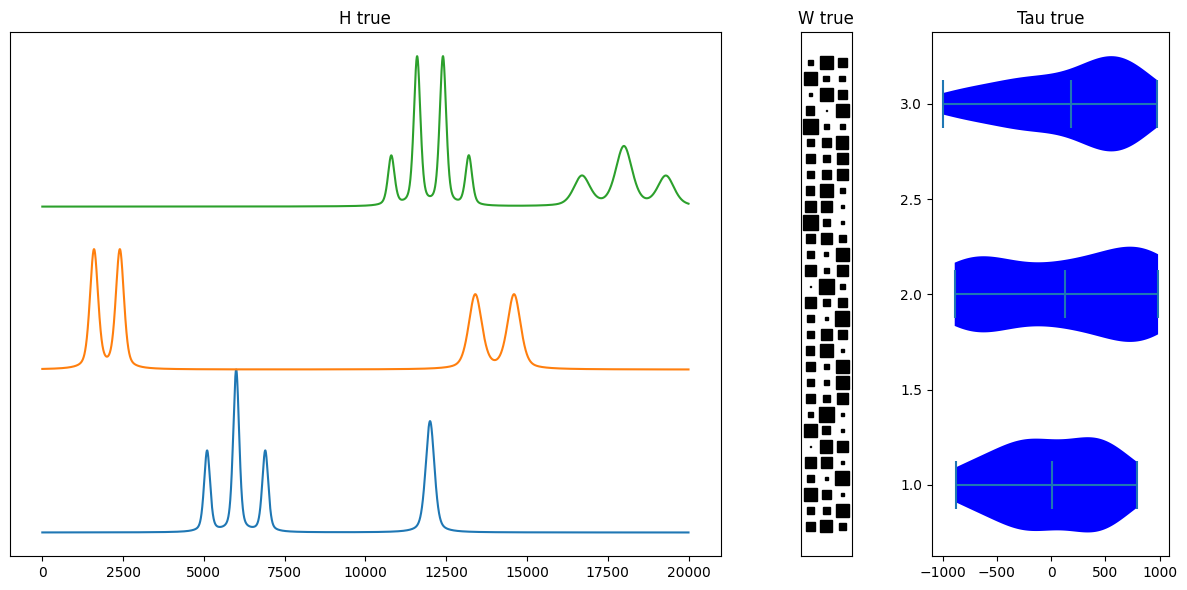

In [2]:
# Create a gridspec object with 2 rows and 3 columns
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X_ART.shape

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_ART.shape[1]), H_ART.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_ART.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(TAU_ART, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# shiftNMF

In [3]:

torch.manual_seed(40)

nmf = ShiftNMF(X_ART_NOISY, 3, lr=0.1, alpha=1e-6, patience=30, min_imp=-10000, normalize_components=False)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0)

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []
losses = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], plot=False)
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas, loss = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    losses.append(loss)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

epoch: 250, Loss: 0.07494357413540881, Tau: 6012.7102873828875
Found peaks:[ 1385  2169  2973 13962 15178]
sigma: 254.799189382446 n:0.999999296930933
sigma: 293.1713537410459 n:3.8738457009548706e-07
sigma: 304.35350515467195 n:0.07741286628528951
sigma: 567.8950462295977 n:2.5912794187277355e-07
sigma: 466.30092956215253 n:0.1785738701546198


[1.0, 0.6965403869494596, 0.10309530110885211, 0.10229529504772683, 0.10221986564803284, 0.10191649271583941, 0.10166633136227216, 0.09815532425892759, 0.09814117525300953]
[0 4 3 1 8 2 5 7 6]


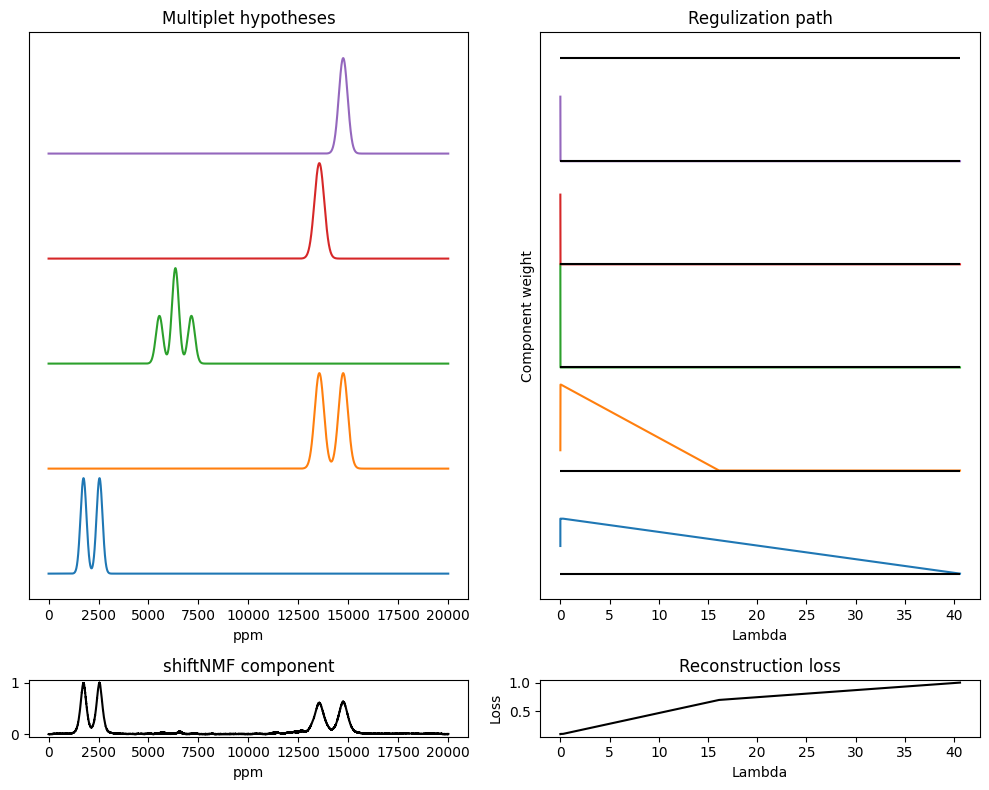

[1.0, 0.8817671582569232, 0.6438886025602224, 0.12963152945455506, 0.12955469562045413, 0.12949447479905618, 0.12949386939669671, 0.12934482776269482]
[ 3 11  0 10  2  7  1  4  5  6  8  9]


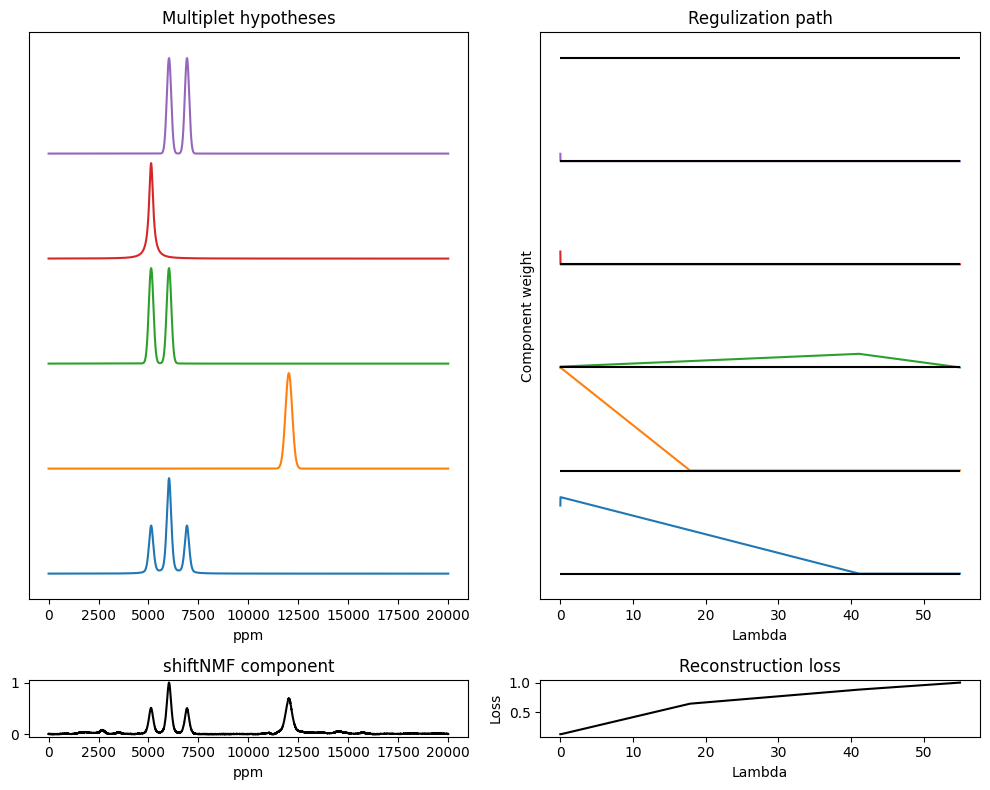

[1.0, 0.49003760504573446, 0.4642664752692798, 0.14640463943861418, 0.12694166070741747, 0.1209036794986062, 0.1185190638161978, 0.1099960244931309, 0.10513734513841297, 0.09451300597455826, 0.09266565675044891, 0.09049149412843387, 0.08961342619414187, 0.08874330864377909, 0.08862926491633244, 0.08825315523416095, 0.08760204077905089, 0.08470196113159849, 0.08330321610894338, 0.08319959456900089, 0.08319055234337526, 0.08310653053721212, 0.08310617308463333, 0.08170316637458824, 0.08154490394761303, 0.08135733593030439, 0.08068965122351518, 0.08053208192555408, 0.08014329460295973, 0.07998720646457824, 0.07954594810612156, 0.07937422562057543, 0.0791245001891367, 0.07872617088823713, 0.07869354120678512, 0.07822737953186318, 0.07817687713557349, 0.07815732166544632, 0.07815539398452595, 0.07791474842874187, 0.07783849958826106, 0.07778645658023091, 0.07777655256809932, 0.07776440702227021, 0.077666980117639, 0.07765698100418825, 0.07759881884608201, 0.0775584791294764, 0.0775244321209

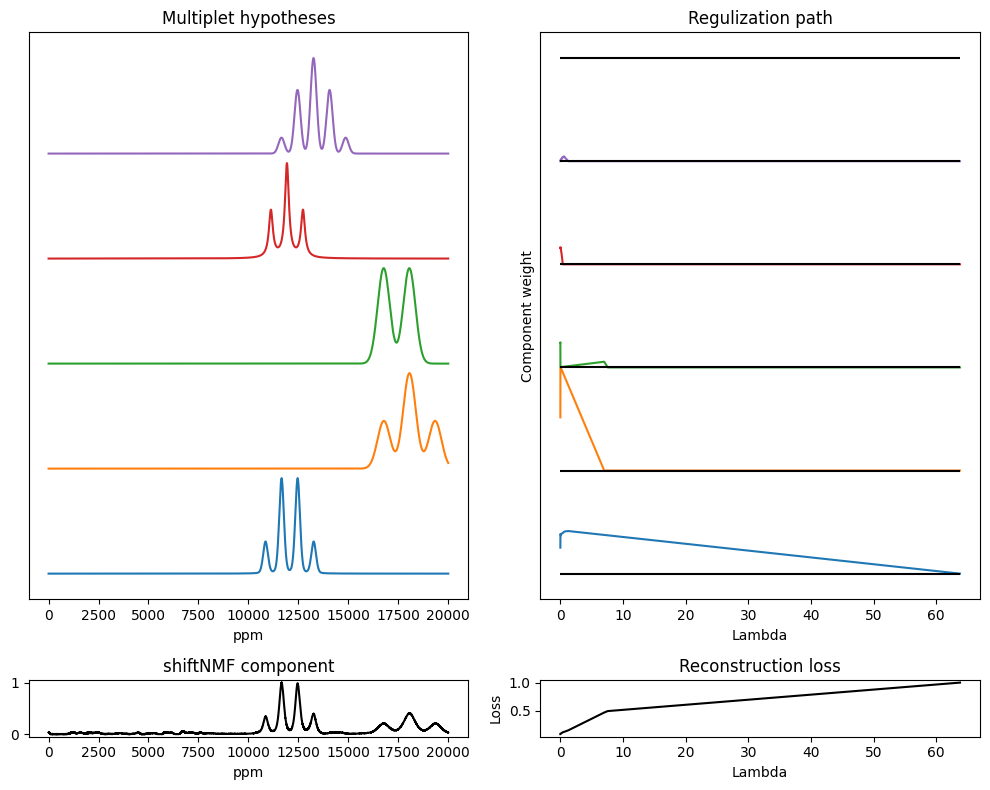

In [ ]:

for i in range(len(reg_paths)):
    path = reg_paths[i][0]
    lambdas = lambda_axis[i][0]
    C = C_path[i]
    loss = losses[i]
    print(loss)
    fig = plt.figure(figsize=(10, 8))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[10,1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regularization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ax3 = plt.subplot(gs[2])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax3.set_title('shiftNMF component')
    ax3.plot(H_est[i]/max(H_est[i]), color="k")
    ax3.set_xlabel("ppm")

    ax4 = plt.subplot(gs[3])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax4.set_title('Reconstruction loss')
    ax4.plot(lambdas, loss, color="k")
    ax4.set_xlabel("Lambda")
    ax4.set_ylabel("Loss")

   
    sort_indices = np.argsort([np.trapz(p,lambdas) for p in path])
    print(sort_indices)
    path = path[sort_indices]
    C = C[sort_indices]

    ymax = 1.1
    yoffset = ymax
    t = 0

    nr_of_components = len(C)

    for j in range(nr_of_components):
            ax1.plot(x,C[j]/max(C[j])+yoffset*t)
            t += 1

    
    ymax = path.max()
    yoffset = ymax
    t = 0
    for j in range(nr_of_components):
            ax2.plot(lambdas,path[j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")


    plt.tight_layout()
    plt.show()

# peak finding (single fit)

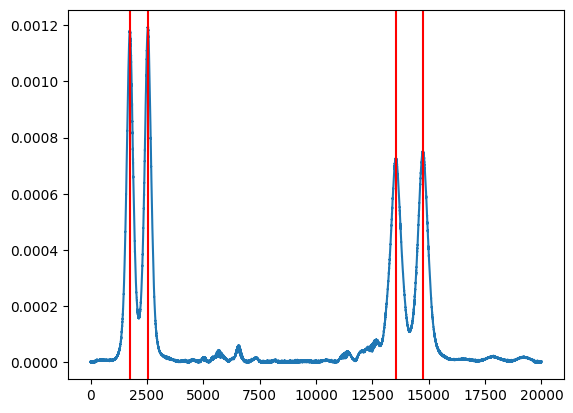

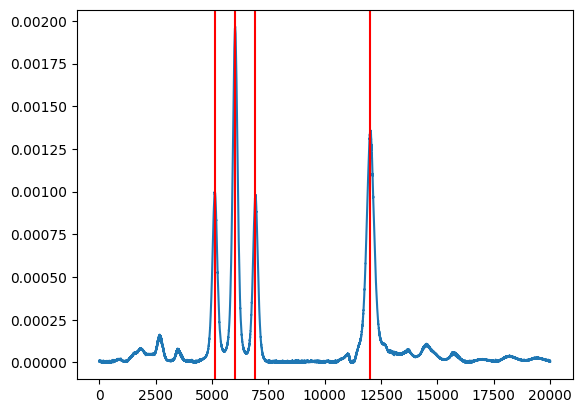

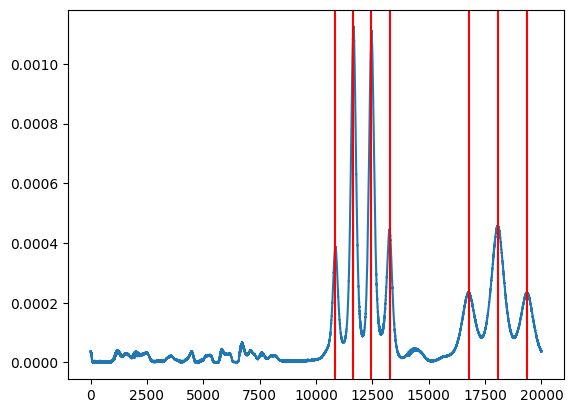

In [5]:

for i in range(len(H_est)):
    plt.plot(H_est[i])
    #peaks = find_peaks_cwt(H_est[i], [100,300])
    peaks = find_peaks(H_est[i], height=max(H_est[i])/10)[0]
    sigmas = scipy.signal.peak_widths(H_est[i], peaks, wlen=1000)[0]/2 #.355*1.5
    select = [sig>100 for sig in sigmas]
    select = [i for i, x in enumerate(select) if x == False]
    sigmas = np.delete(sigmas, select)
    peaks = np.delete(np.array(peaks), select)
    for mean in peaks:
        plt.axvline(mean, color='r')
    plt.show()

# Hardmodel

In [6]:
for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()

Found peaks:[ 1748  2549 13549 14743]


KeyboardInterrupt: 